In [1]:
import os
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import torch.nn.functional as F
import sys
import collections
import random
import tarfile

os.environ["CUDA_VISIBLE_DEVICES"]="0"
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT='./S1/CSCL/tangss/Datasets'

# 一维卷积层

In [2]:
def corr1d(X,K):
    w=K.shape[0]
    Y=torch.zeros((X.shape[0]-w+1))
    for i in range(Y.shape[0]):
        Y[i]=(X[i:i+w]*K).sum()
    return Y

In [3]:
X,K=torch.tensor([0,1,2,3,4,5,6]),torch.tensor([1,2])
corr1d(X,K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [4]:
def corr1d_multi_in(X,K):
    return torch.stack([corr1d(x,k) for x,k in zip(X,K)]).sum(dim=0)
X=torch.tensor([[0,1,2,3,4,5,6],
               [1,2,3,4,5,6,7],
               [2,3,4,5,6,7,8]])
K=torch.tensor([[1,2],
               [3,4],
               [-1,-3]])
corr1d_multi_in(X,K)

tensor([ 2.,  8., 14., 20., 26., 32.])

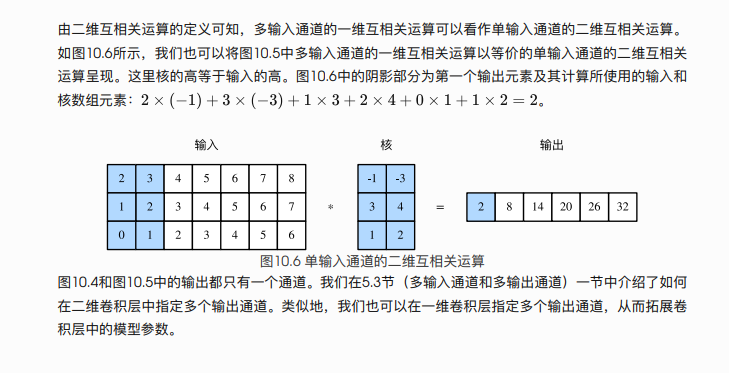

# 时序最大池化层

In [5]:
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d,self).__init__()
    def forward(self,x):
        return F.max_pool1d(x,kernel_size=x.shape[2])

# 读取和预处理IMDB数据集

In [6]:
fname=os.path.join(DATA_ROOT,'aclImdb_v1.tar.gz')
if not os.path.exists(os.path.join(DATA_ROOT,'aclImdb')):
    print('从压缩包解压...')
    with tarfile.open(fname,'r') as f:
        f.extractall(DATA_ROOT)

In [7]:
from tqdm import tqdm
def read_imdb(folder='train',data_root="./S1/CSCL/tangss/Datasets/aclImdb"):
    data=[]
    for label in ['pos','neg']:
        folder_name=os.path.join(data_root,folder,label)
        for file in tqdm(os.listdir(folder_name)):
            with open(os.path.join(folder_name,file),'rb') as f:
                review=f.read().decode('utf-8').replace('\n','').lower()
                data.append([review,1 if label=='pos' else 0])
    random.shuffle(data)
    return data
train_data,test_data=read_imdb('train'),read_imdb('test')

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:09<00:00, 1300.82it/s]


In [8]:
def get_tokenized_imdb(data):
    def tokenizer(text):
        return [tok.lower() for tok in text.split(' ')]
    return [tokenizer(review) for review,_ in data]

In [9]:
def get_vocab_imdb(data):
    tokenized_data=get_tokenized_imdb(data)
    counter=collections.Counter([tk for st in tokenized_data for tk in st])
    return Vocab.Vocab(counter,min_freq=5)
vocab=get_vocab_imdb(train_data)
'#words in vocab:',len(vocab)

('#words in vocab:', 46152)

In [10]:
def preprocess_imdb(data,vocab):
    max_l=500
    def pad(x):
        return x[:max_l] if len(x)>max_l else x+[0]*(max_l-len(x))
    tokenized_data=get_tokenized_imdb(data)
    features=torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    labels=torch.tensor([score for _,score in data])
    return features,labels

In [11]:
batch_size=64
train_set=Data.TensorDataset(*preprocess_imdb(train_data,vocab))
test_set=Data.TensorDataset(*preprocess_imdb(test_data,vocab))
train_iter=Data.DataLoader(train_set,batch_size,shuffle=True)
test_iter=Data.DataLoader(test_set,batch_size)

# TEXTCNN模型

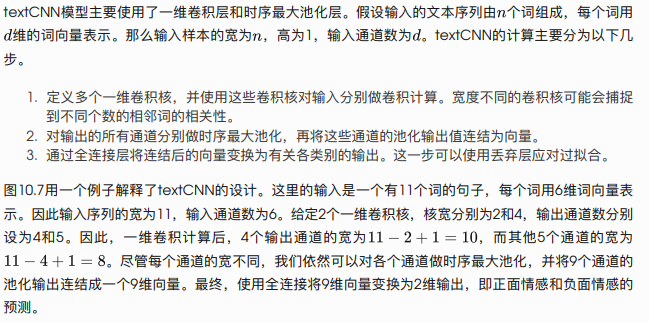

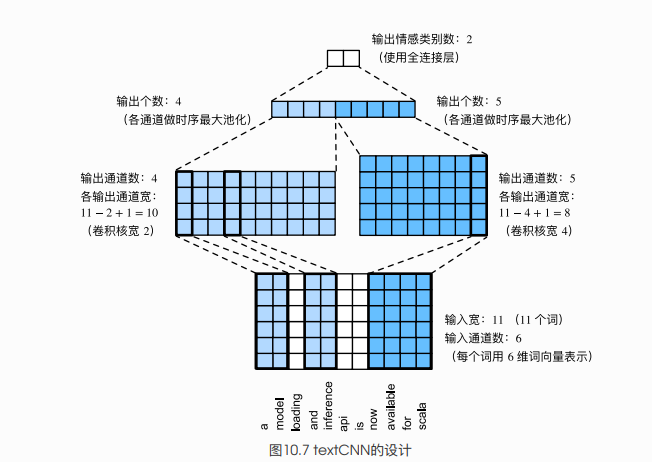

In [12]:
class TextCNN(nn.Module):
    def __init__(self,vocab,embed_size,kernel_sizes,num_channels):
        super(TextCNN,self).__init__()
        self.embedding=nn.Embedding(len(vocab),embed_size)
        #不参与训练的嵌入层
        self.constant_embedding=nn.Embedding(len(vocab),embed_size)
        self.droput=nn.Dropout(0.5)
        self.decoder=nn.Linear(sum(num_channels),2)
        #时序最大池化层没有权重，所以可以共用一个实例
        self.pool=GlobalMaxPool1d()
        self.convs=nn.ModuleList()#创建多个一维卷积层
        for c,k in zip(num_channels,kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels=2*embed_size,out_channels=c,kernel_size=k))
    def forward(self,inputs):
        embeddings=torch.cat((self.embedding(inputs),self.constant_embedding(inputs)),dim=2)
        embeddings=embeddings.permute(0,2,1)
        encoding=torch.cat([self.pool(F.relu(conv(embeddings))).squeeze(-1) for conv in self.convs],dim=1)
        outputs=self.decoder(self.droput(encoding))
        return outputs

In [13]:
embed_size,kernel_size,num_channels=100,[3,4,5],[100,100,100]
net=TextCNN(vocab,embed_size,kernel_size,num_channels)

# 加载预训练的词向量

In [14]:
def load_pretrained_embedding(words,pretrained_vocab):
    embed=torch.zeros(len(words),pretrained_vocab.vectors[0].shape[0])
    oov_count=0
    for i,word in enumerate(words):
        try:
            idx=pretrained_vocab.stoi[word]
            embed[i,:]=pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count+=0
    if oov_count>0:
        print('there are %d oov words.'%oov_count)
    return embed

In [15]:
glove_vocab=Vocab.GloVe(name='6B',dim=100,cache='./Datasets/glove')
net.embedding.weight.data.copy_(load_pretrained_embedding(vocab.itos,glove_vocab))
net.constant_embedding.weight.data.copy_(load_pretrained_embedding(vocab.itos,glove_vocab))
net.constant_embedding.weight.requires_grad=False

# 训练并评价模型

In [16]:
import time
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on ',device)
    loss=torch.nn.CrossEntropyLoss()
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.lf sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))

In [17]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

In [18]:
lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(filter(lambda p:p.requires_grad,net.parameters()),lr=lr)
loss=nn.CrossEntropyLoss()
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda
epoch 1,loss 0.4832,train acc 0.758,test acc 0.848,time 160 sec
epoch 2,loss 0.1602,train acc 0.864,test acc 0.871,time 154 sec
epoch 3,loss 0.0702,train acc 0.919,test acc 0.858,time 154 sec
epoch 4,loss 0.0295,train acc 0.957,test acc 0.871,time 154 sec
epoch 5,loss 0.0129,train acc 0.977,test acc 0.867,time 155 sec


In [19]:
def predict_sentiment(net,vocab,sentence):
    device=list(net.parameters())[0].device
    sentence=torch.tensor([vocab.stoi[word] for word in sentence],device=device)
    label=torch.argmax(net(sentence.view((1,-1))),dim=1)
    return 'positive' if label.item()==1 else 'negative'

In [29]:
predict_sentiment(net,vocab,['i','am','bad','today','.'])

'negative'

In [33]:
ss='I want to see the movie after I see it'
sslist=ss.split()
print(sslist)

['I', 'want', 'to', 'see', 'the', 'movie', 'after', 'I', 'see', 'it']


In [34]:
predict_sentiment(net,vocab,sslist)

'positive'